## Predict Students Dropout - Ensemble Learning

06_ml_ensample_learning_students_dropout.ipynb

This notebook focuses on building and evaluating ensemble learning models to predict student dropout. The steps include reading the prepared data, implementing various ensemble techniques, and comparing their performance.

Ensemble learning is a distinct and advanced technique that combines multiple models to improve prediction accuracy

Steps
1. Read in Prepared Data: Load the prepared data from the previously saved CSV file.
2. Handle Missing Values: Handle any missing values in the dataset.
3. Split Features and Target Variables: Separate the feature variables (X) and the target variable (y).
4. Split Training and Testing Data: Split the dataset into training and testing sets to evaluate model performance.
5. Implement Ensemble Learning Techniques: Construct and evaluate various ensemble learning models.
6. Compare Model Performance: Compare the performance of different ensemble models to select the best one.
7. Visualise Model Performance: Visualise the performance metrics of the ensemble models.

### Import packages

In [71]:
# Importing libraries

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Read in Prepared Data

In [72]:
# Load the data
df_student = pd.read_csv('data/prep_data.csv')

### Step 2: Handle Missing Values

In [73]:
# Handle Missing Values
df_student.fillna(df_student.mean(), inplace=True)

### Step 3: Split Features and Target Variables

In [74]:
# Define features and Target_encoded
y = df_student['Target_encoded']
X = df_student.drop(columns=['Target_encoded'])  # Replace 'Target_encoded' with your Target_encoded column

### Step 4: Split Training and Testing Data

In [75]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 5: Implement Ensemble Learning Techniques

Logistic Regression F1 Score on Training Data: 0.9091
Logistic Regression F1 Score on Test Data: 0.8994
Random Forest F1 Score on Training Data: 0.9845
Random Forest F1 Score on Test Data: 0.9080
SVC F1 Score on Training Data: 0.9383
SVC F1 Score on Test Data: 0.9008
XGBoost F1 Score on Training Data: 0.9319
XGBoost F1 Score on Test Data: 0.9082
Voting Classifier F1 Score on Training Data: 0.9429
Voting Classifier F1 Score on Test Data: 0.9136


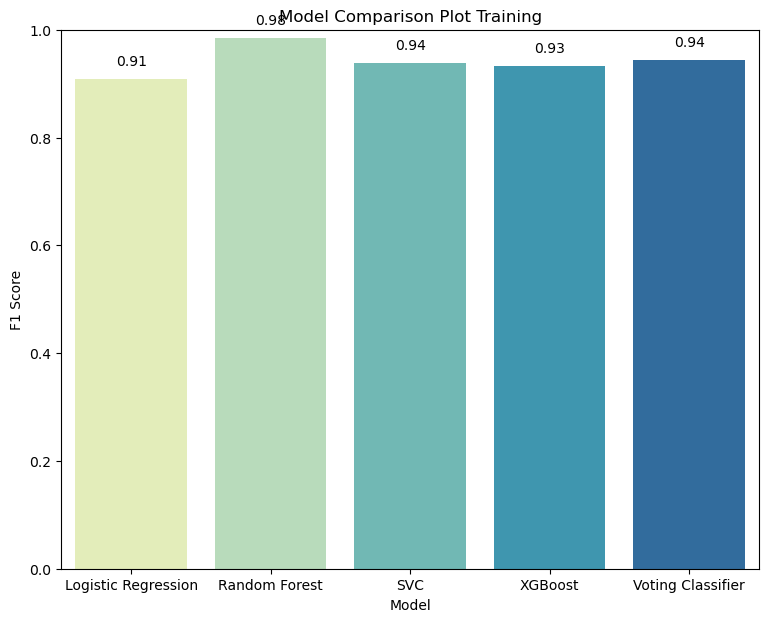

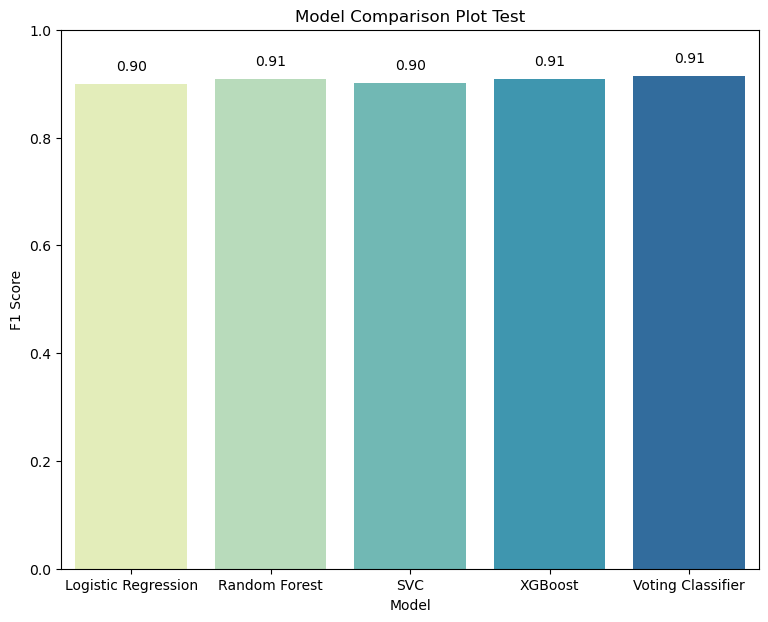

In [76]:
# Create pipelines for different models with an imputer for missing values
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=2000, random_state=42))
])

pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier(random_state=42))
])

pipeline_svc = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=42))
])

pipeline_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='mlogloss'))
])

# Define the hyperparameters to tune for each model
param_grid_lr = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'logistic__solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga']
}

param_grid_rf = {
    'random_forest__n_estimators': [50, 100],  # Number of trees
    'random_forest__max_depth': [None, 10, 20],
    'random_forest__min_samples_split': [2, 5],
    'random_forest__min_samples_leaf': [1, 2],
}

param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [1, 0.1, 0.01],
    'svc__kernel': ['rbf']
}

param_grid_xgb = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 1]
}

# Perform grid search with cross-validation for each model
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
best_model_lr = grid_search_lr.best_estimator_

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_estimator_

grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svc.fit(X_train, y_train)
best_model_svc = grid_search_svc.best_estimator_

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_model_xgb = grid_search_xgb.best_estimator_

# Define the VotingClassifier with all models
voting_clf = VotingClassifier(estimators=[
    ('lr', best_model_lr),
    ('rf', best_model_rf),
    ('svc', best_model_svc),
    ('xgb', best_model_xgb)
], voting='soft')

voting_clf.fit(X_train, y_train)

# Evaluate the models on training and test data
models = {
    'Logistic Regression': best_model_lr,
    'Random Forest': best_model_rf,
    'SVC': best_model_svc,
    'XGBoost': best_model_xgb,
    'Voting Classifier': voting_clf
}

f1_scores_train = {}
f1_scores_test = {}

for model_name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    f1_scores_train[model_name] = f1_score(y_train, y_train_pred, average='weighted')
    f1_scores_test[model_name] = f1_score(y_test, y_test_pred, average='weighted')
    print(f"{model_name} F1 Score on Training Data: {f1_scores_train[model_name]:.4f}")
    print(f"{model_name} F1 Score on Test Data: {f1_scores_test[model_name]:.4f}")

# Visualization of model comparison
def barplot_models(model_scores, title):
    model_names = list(model_scores.keys())
    f1_scores = list(model_scores.values())
    plt.figure(figsize=(9, 7))
    sns.set_palette("YlGnBu")
    bars = sns.barplot(x=model_names, y=f1_scores)
    plt.title(title)
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    for bar, f1_score in zip(bars.patches, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{f1_score:.2f}", ha="center", va="bottom")
    plt.show()

barplot_models(model_scores=f1_scores_train, title="Model Comparison Plot Training")
barplot_models(model_scores=f1_scores_test, title="Model Comparison Plot Test")

In [77]:
# Base models
logisticRegr = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(random_state=42)
svc_model = SVC(random_state=42, probability=True)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', logisticRegr),
    ('rf', rf_model),
    ('svc', svc_model)
], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

# Bagging Classifier
bagging_clf = BaggingClassifier(estimator=logisticRegr, n_estimators=10, random_state=42)
bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)

# AdaBoost Classifier
adaboost_clf = AdaBoostClassifier(estimator=logisticRegr, n_estimators=50, random_state=42)
adaboost_clf.fit(X_train, y_train)
y_pred_adaboost = adaboost_clf.predict(X_test)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)


/Users/youssef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/youssef/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [78]:
# Function to evaluate model performance
def evaluate_model_performance(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {accuracy:.2f}%")
    print(f"{model_name} - F1 Score: {f1:.2f}")
    print(f"{model_name} - Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{model_name} - Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return accuracy, f1

# Evaluate Voting Classifier
voting_accuracy, voting_f1 = evaluate_model_performance(y_test, y_pred_voting, "Voting Classifier")

# Evaluate Bagging Classifier
bagging_accuracy, bagging_f1 = evaluate_model_performance(y_test, y_pred_bagging, "Bagging Classifier")

# Evaluate AdaBoost Classifier
adaboost_accuracy, adaboost_f1 = evaluate_model_performance(y_test, y_pred_adaboost, "AdaBoost Classifier")

# Evaluate Gradient Boosting Classifier
gb_accuracy, gb_f1 = evaluate_model_performance(y_test, y_pred_gb, "Gradient Boosting Classifier")

# Compare Ensemble Model Performance
ensemble_performance = {
    'Model': ['Voting Classifier', 'Bagging Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier'],
    'Accuracy': [voting_accuracy, bagging_accuracy, adaboost_accuracy, gb_accuracy],
    'F1 Score': [voting_f1, bagging_f1, adaboost_f1, gb_f1]
}

performance_df = pd.DataFrame(ensemble_performance)
print(performance_df)


Voting Classifier - Accuracy: 0.91%
Voting Classifier - F1 Score: 0.91
Voting Classifier - Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       277
           1       0.90      0.96      0.93       449

    accuracy                           0.91       726
   macro avg       0.92      0.89      0.90       726
weighted avg       0.91      0.91      0.91       726

Voting Classifier - Confusion Matrix:
 [[229  48]
 [ 17 432]]
Bagging Classifier - Accuracy: 0.89%
Bagging Classifier - F1 Score: 0.89
Bagging Classifier - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       277
           1       0.89      0.93      0.91       449

    accuracy                           0.89       726
   macro avg       0.89      0.87      0.88       726
weighted avg       0.89      0.89      0.89       726

Bagging Classifier - Confusion Matrix:
 [[226  51]


### Step 6: Evaluate and Compare Ensemble Model Performance

Stacking Classifier F1 Score on Training Data: 0.9458
Stacking Classifier F1 Score on Test Data: 0.9071


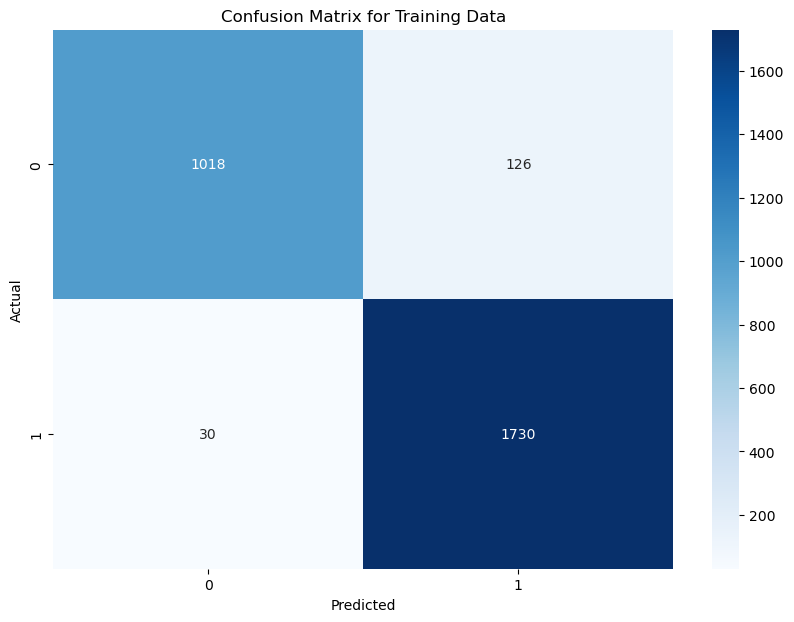

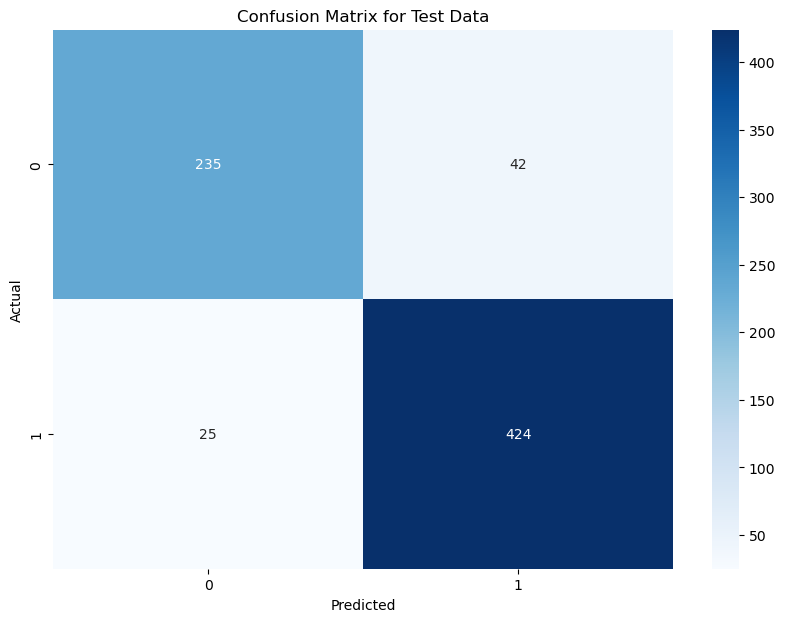

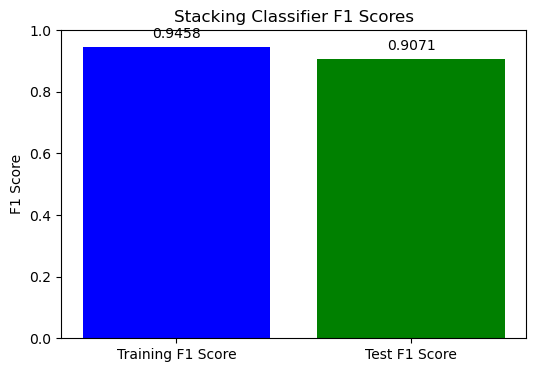

In [79]:
# Define base learners
base_learners = [
    ('lr', best_model_lr),
    ('rf', best_model_rf),
    ('svc', best_model_svc),
    ('xgb', best_model_xgb)
]

# Define meta-learner
meta_learner = LogisticRegression()

# Create stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=3)

# Fit stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate the stacking classifier
y_train_pred_stacking = stacking_clf.predict(X_train)
y_test_pred_stacking = stacking_clf.predict(X_test)

# Calculate F1 scores
f1_score_train_stacking = f1_score(y_train, y_train_pred_stacking, average='weighted')
f1_score_test_stacking = f1_score(y_test, y_test_pred_stacking, average='weighted')

print(f"Stacking Classifier F1 Score on Training Data: {f1_score_train_stacking:.4f}")
print(f"Stacking Classifier F1 Score on Test Data: {f1_score_test_stacking:.4f}")

# Calculate confusion matrix for train and test predictions
conf_matrix_train = confusion_matrix(y_train, y_train_pred_stacking)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_stacking)

# Plot the confusion matrices
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(conf_matrix_train, "Confusion Matrix for Training Data")
plot_confusion_matrix(conf_matrix_test, "Confusion Matrix for Test Data")

# Visualization of F1 scores
def plot_f1_scores(f1_train, f1_test, title):
    plt.figure(figsize=(6, 4))
    plt.bar(['Training F1 Score', 'Test F1 Score'], [f1_train, f1_test], color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel('F1 Score')
    for i, v in enumerate([f1_train, f1_test]):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
    plt.show()

plot_f1_scores(f1_score_train_stacking, f1_score_test_stacking, "Stacking Classifier F1 Scores")

/Users/youssef/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Boosting Classifier F1 Score on Training Data: 0.9315
Boosting Classifier F1 Score on Test Data: 0.9174


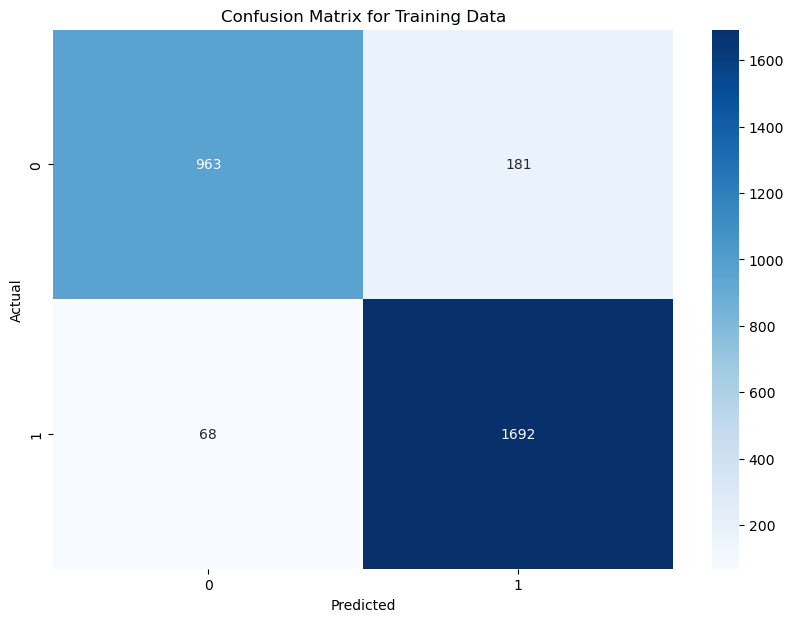

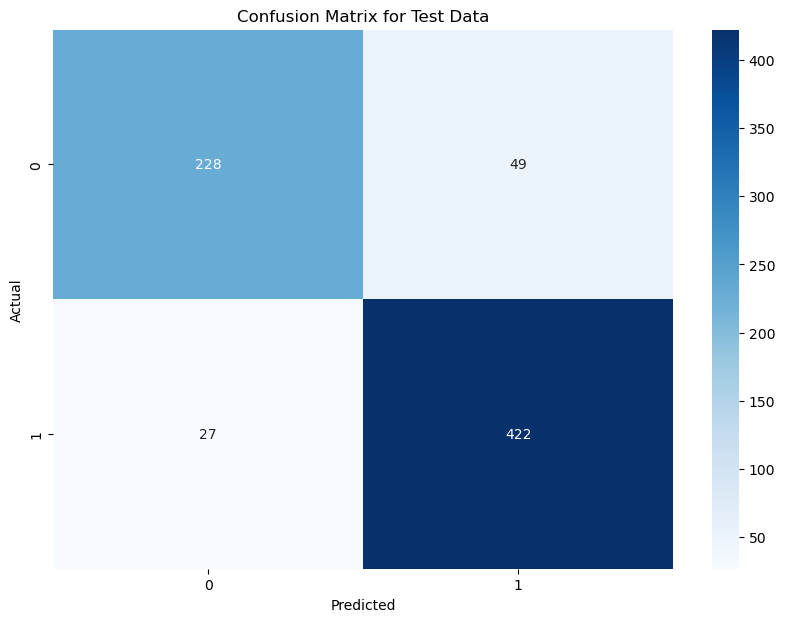

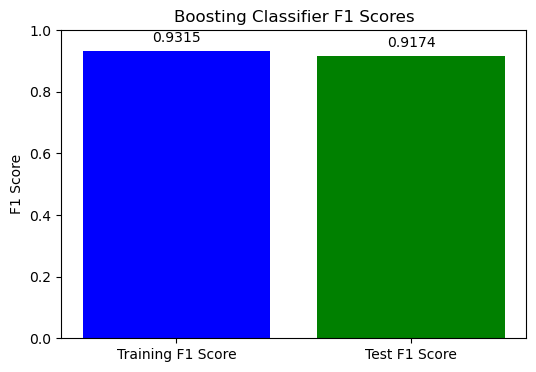

Boosting Classifier F1 Score on Training Data: 0.9315
Boosting Classifier F1 Score on Test Data: 0.9174


In [80]:
# Create an AdaBoost classifier
boosting_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42)

# Fit boosting classifier
boosting_clf.fit(X_train, y_train)

# Evaluate the boosting classifier
y_train_pred_boosting = boosting_clf.predict(X_train)
y_test_pred_boosting = boosting_clf.predict(X_test)

# Calculate F1 scores
f1_score_train_boosting = f1_score(y_train, y_train_pred_boosting)
f1_score_test_boosting = f1_score(y_test, y_test_pred_boosting)

print(f"Boosting Classifier F1 Score on Training Data: {f1_score_train_boosting:.4f}")
print(f"Boosting Classifier F1 Score on Test Data: {f1_score_test_boosting:.4f}")


# Calculate confusion matrix for train and test predictions
conf_matrix_train = confusion_matrix(y_train, y_train_pred_boosting)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_boosting)

# Plot the confusion matrices
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(conf_matrix_train, "Confusion Matrix for Training Data")
plot_confusion_matrix(conf_matrix_test, "Confusion Matrix for Test Data")

# Visualization of F1 scores
def plot_f1_scores(f1_train, f1_test, title):
    plt.figure(figsize=(6, 4))
    plt.bar(['Training F1 Score', 'Test F1 Score'], [f1_train, f1_test], color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel('F1 Score')
    for i, v in enumerate([f1_train, f1_test]):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
    plt.show()

plot_f1_scores(f1_score_train_boosting, f1_score_test_boosting, "Boosting Classifier F1 Scores")

print(f"Boosting Classifier F1 Score on Training Data: {f1_score_train_boosting:.4f}")
print(f"Boosting Classifier F1 Score on Test Data: {f1_score_test_boosting:.4f}")


In [81]:
# Function to evaluate model performance
def evaluate_model_performance(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {accuracy:.2f}%")
    print(f"{model_name} - F1 Score: {f1:.2f}")
    print(f"{model_name} - Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{model_name} - Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return accuracy, f1

# Evaluate Voting Classifier
voting_accuracy, voting_f1 = evaluate_model_performance(y_test, y_pred_voting, "Voting Classifier")

# Evaluate Bagging Classifier
bagging_accuracy, bagging_f1 = evaluate_model_performance(y_test, y_pred_bagging, "Bagging Classifier")

# Evaluate AdaBoost Classifier
adaboost_accuracy, adaboost_f1 = evaluate_model_performance(y_test, y_pred_adaboost, "AdaBoost Classifier")

# Evaluate Gradient Boosting Classifier
gb_accuracy, gb_f1 = evaluate_model_performance(y_test, y_pred_gb, "Gradient Boosting Classifier")

# Compare Ensemble Model Performance
ensemble_performance = {
    'Model': ['Voting Classifier', 'Bagging Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier'],
    'Accuracy': [voting_accuracy, bagging_accuracy, adaboost_accuracy, gb_accuracy],
    'F1 Score': [voting_f1, bagging_f1, adaboost_f1, gb_f1]
}

performance_df = pd.DataFrame(ensemble_performance)
print(performance_df)


Voting Classifier - Accuracy: 0.91%
Voting Classifier - F1 Score: 0.91
Voting Classifier - Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       277
           1       0.90      0.96      0.93       449

    accuracy                           0.91       726
   macro avg       0.92      0.89      0.90       726
weighted avg       0.91      0.91      0.91       726

Voting Classifier - Confusion Matrix:
 [[229  48]
 [ 17 432]]
Bagging Classifier - Accuracy: 0.89%
Bagging Classifier - F1 Score: 0.89
Bagging Classifier - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       277
           1       0.89      0.93      0.91       449

    accuracy                           0.89       726
   macro avg       0.89      0.87      0.88       726
weighted avg       0.89      0.89      0.89       726

Bagging Classifier - Confusion Matrix:
 [[226  51]


### Step 7: Visualise Ensemble Model Performance

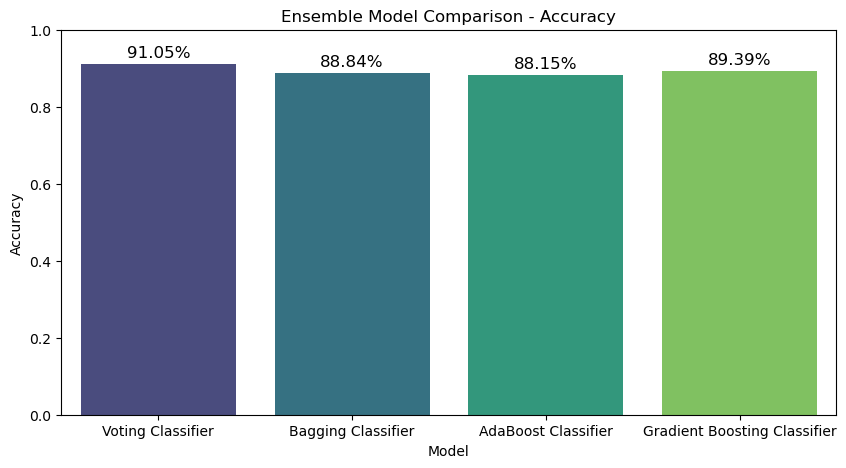

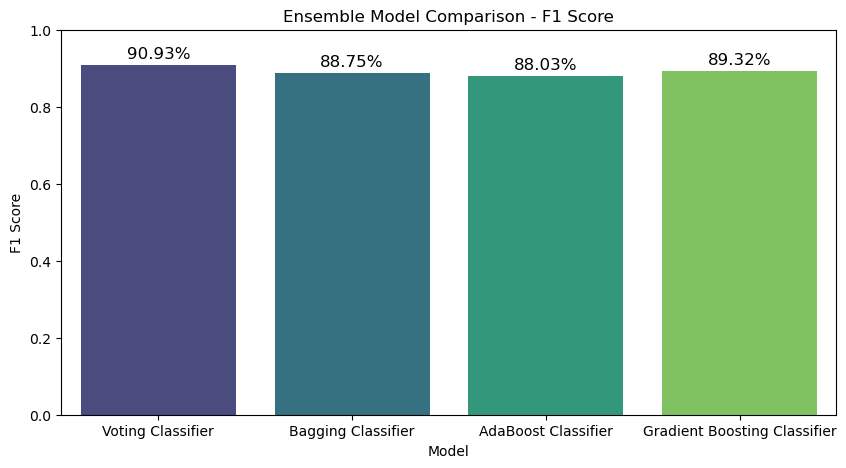

In [82]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
bars = sns.barplot(x='Model', y='Accuracy', data=performance_df, palette='viridis')
plt.title('Ensemble Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
for bar in bars.patches:
    bars.annotate(f'{bar.get_height()*100:.2f}%',
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='center', size=12, xytext=(0, 8),
                  textcoords='offset points')
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 5))
bars = sns.barplot(x='Model', y='F1 Score', data=performance_df, palette='viridis')
plt.title('Ensemble Model Comparison - F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.ylim(0, 1)
for bar in bars.patches:
    bars.annotate(f'{bar.get_height()*100:.2f}%',
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='center', size=12, xytext=(0, 8),
                  textcoords='offset points')
plt.show()
